# Анализ характеристик тандемной сети с помощью аппроксимации выходных потоков

Исследуем различные методы расчета **межконцевых задержек** и **вероятностей потери** пакетов в тандемных сетях с узлами MAP/PH/1/N. 

В этом ноутбуке мы изучим три способа расчета характеристик тандемной сети с узлами MAP/PH/1/N:

- точный расчет;
- расчет с аппроксимацией потоков;
- расчет методом Монте-Карло.


Проведем два эксперимента:

1) Проверим точность приближенных методов сравнением с точным решением.
2) Сравним точность и время расчета имитационной модели и метода аппроксимации выходных потоков на сетях большого размера.

В первом эксперименте нам придется использовать PH и MAP маленьких порядокв, небольшую емкость очереди и небольшое число станций. 
Это связано с тем, что размерность задачи растет экспоненциально с ростом размера сети, а именно как $O(W(VM)^N)$, где $W$ - порядок
MAP-потока, $V$ - порядок PH-распределений, $M$ - емкость очереди, а $N$ - число станций в сети. Для этого эксперимента мы будем
строить данные двумя способами: 

- произвольные MAP-ы, PH-распределения и длины очередей, но с не одной, двумя или тремя станциями в сети
- простейшие MAP-потоки и PH-распределения (то есть экспоненты) и малые длины очередей (до двух), но с большим числом станций в сети

Для второго эксперимента такого явного ограничения нет, хотя из-за того, что в итерационном расчете с аппроксимациями все равно
приходится строить выходящий поток, все равно будем ограничивать размеры MAP и PH.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install tarjan seaborn

## Подготовка ноутбука и загрузка данных

Сначала импортируем и настроим нужные нам библиотеки, а также определим функции для сохранения и загрузки данных.

In [3]:
from dataclasses import dataclass
import os
from itertools import product
from time import perf_counter
from typing import Optional, Dict, Union, Sequence
import multiprocessing
import locale

# Библиотеки для работы с данными
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from tabulate import tabulate
tqdm.pandas()  # Делаем доступными функции типа df.progress_apply()

from tarjan import tarjan

import pyqumo
import pyqumo.algorithms
from pyqumo.utils.plots import get_color
from pyqumo.utils.text import highlight as hl, fmt_err, TextColor
from pyqumo import rel_err, MarkovArrival, PhaseType, Erlang, \
    HyperExponential, Exponential
from pyqumo.algorithms.networks.mapph1n_tandem import solve_iterative, SolveResults

# Библиотеки для рисования графиков
import matplotlib
from matplotlib import pyplot as plt, cm
from matplotlib.lines import Line2D
import seaborn as sns

pd.options.mode.chained_assignment = None  # default='warn'

from bin.map_tandem import load_data, save_data

Настроим рисование графиков.

In [30]:
# Настраиваем matplotlib
%matplotlib inline
CMAP_NAME = 'inferno'  # Цветовая схема для графиков
LIGHT_CMAP = cm.get_cmap("Pastel2")
SCATTER_CMAP_NAME = "flare"

matplotlib.rcParams.update({
    'image.cmap': CMAP_NAME,
    'axes.formatter.use_locale': True,
    'font.size': 16,
    'font.family': 'sans-serif',
    'legend.title_fontsize': 'large',
    
    # Шрифт PT Serif Caption можно установить с Google Fonts.
    # После установки шрифта нужно удалить кэш matplitlib,
    # на Ubuntu: ~/.cache/matplotlib 
    'font.sans-serif': ['PT Serif Caption'],
})

locale.setlocale(locale.LC_ALL, 'ru_RU.UTF-8')

'ru_RU.UTF-8'

Для удобства форматирования определим функции для вывода цветных строчек.

In [5]:
def fmt_header(s):
    return hl(s, TextColor.OKBLUE)
    
def fmt_delim(s):
    return hl(s, TextColor.OKCYAN)

def fmt_float(x):
    return f'{x:.4f}'

def fmt_yes_no(x, yes_is_good: bool = True):
    color = TextColor.OKGREEN if x and yes_is_good else TextColor.FAIL
    return hl('yes' if x else 'no', color, TextColor.BOLD)

Для более удобной работы с графиками определим функции сохранения построенного изображения.

In [6]:
IMAGE_BASE_DIR = "images"  # Здесь будут храниться все построенные изображения

def savefig(out: Union[str, Sequence[str]] = ()):
    if out:
        if isinstance(out, str):
            out = (out,)
        for file_name in out:
            file_path = os.path.join(IMAGE_BASE_DIR, file_name)
            plt.savefig(file_path, bbox_inches="tight")

### Функции для сохранения и загрузки данных

В датафреймах, с которыми мы будем работать, будут колонки, в которых содержатся MAP-потоки и PH-распределения. Их неудобно сериализовывать
в чистом виде, поэтому при сохранении в файл мы будем брать только матрицы и записывать их в новые колонки, а при загрузке - строить колонки
для MAP-потока (`"arrival"`) и PH-распределения (`"service"`).

Определим две важные константы:

- `DATA_CSV`: путь к файлу, в котором будут храниться наши данные со случайными MAP-потоками и PH-распределениями.
- `FORCE_COMPUTE`: флаг, устанавливающий, нужно ли выполнять генерацию выборки, если даже она была успешно загружена из CSV-файла.

Если данных в CSV-файле нет, то код будет выполняться независимо от значения `FORCE_COMPUTE`.

In [7]:
DATA_CSV = os.path.join('data', 'tandems_data.csv')
FORCE_COMPUTE = False

In [8]:
file_name_ = hl(DATA_CSV, TextColor.BOLD)

if not os.path.exists(DATA_CSV):
    print(f"> File '{file_name_}' not found, I will generate generic data and save it later.")
if FORCE_COMPUTE:
    if os.path.exists(DATA_CSV):
        print(hl(f"> Data in '{DATA_CSV}' will be overwritten.", TextColor.WARNING, TextColor.BOLD))
else:
    if os.path.exists(DATA_CSV):
        print(f"> I will use '{file_name_}' for experiment data")

del file_name_

> I will use 'data/tandems_data.csv' for experiment data


## Генерирование случайных параметров

Для проведения эксперимента мы будем генерировать случайные MAP-потоки и PH-распределения. MAP-потоки будем строить
по заданному PH, подбирая распределение под значение коэффициента автокорреляции. Чтобы распределения действительно различались
и генерация была эффективной, мы будем выбирать случайные значения коэффициента вариации и коэффициента симметрии, а для
процесса обслуживания - и среднего интервала между пакетами, и по ним, методом моментов, находить PH-распределение.

Так как все численные методы, которые мы будем применять, очень чувствительны к порядкам распределений (например, нам
потребуется много раз решать системы линейных уравнений, а эта задача имеет третий порядок), то будем ограничивать максимальный
порядок распределений. При этом, для некоторых значений коэффициентов вариации и симметрии мы не сможем подобрать PH - это
не так критично в нашей задаче, как потеря нескольких часов на расчет.

Чтобы немного упростить задачу, будем полагать интенсивность (и среднее значение интервалов) входящих потоков равными единице.

> Пусть $m_s = 1/\mu$ - среднее время обслуживания. Если $\lambda = 1$, то $\rho = \frac{\lambda}{\mu} = \mu^{-1} = m_s$.

> Будем называть $\rho = \lambda / \mu$ **коэффициентом загрузки** (**busy**, **busy ratio**), хотя в действительности для 
> системы с конечной емкостью очереди загрузка считается не совсем так - нужно учитывать потери.

Остальные параметры будем выбирать так:

- Загрузку на первой фазе будем выбирать из интервала `[MIN_BUSY, MAX_BUSY]`
- Коэффициенты вариации будем брать из интервала `[MIN_CV, MAX_CV]`
- Коэффициенты асимметрии будем брать из интервала `[cv - 1/cv, MAX_SKEW]`, где `cv` - выбранный коэффициент вариации
- Коэффициент автокорреляции будем брать из интервала `[MIN_LAG, MAX_LAG]`
- Размер сети будет выбираться из `1, 2, ..., MAX_NET_SIZE`
- Емкость очереди будет выбираться из `0, 1, ..., MAX_CAPACITY`
- Если найденное распределение будет иметь порядок, больший, чем `MAX_PH_ORDER`, то оно будет обрезаться

Общее число сэмплов зададим в `NUM_SAMPLES`.

In [9]:
ARRIVAL_RATE = 1                       # интенсивность входящего потока
MIN_BUSY = 0.1                         # минимальный коэффициент загрузки
MAX_BUSY = 1.5                         # максимальный коффициент загрузки
MIN_CV = 0.5                           # минимальный коэффициент вариации
MAX_CV = 4.0                           # максимальный коэффициент вариации
MAX_SKEW = 6.0                         # максимальный коэффициент асимметрии
MIN_LAG = -0.01                        # минимальный коэффициент автокорреляции с лагом 1
MAX_LAG = 0.3                          # максимальный коэффициент автокорреляции с лагом 1
MAX_NET_SIZE = 10                      # максимальный размер сети
MAX_CAPACITY = 10                      # максимальная емкость очереди
NUM_SAMPLES = 500                      # число произвольных сэмплов
NUM_BASIC_SAMPLES = 100                # число дополнительных сэмплов с простыми распределениями
MAX_PH_ORDER = 10                      # максимальный порядок генерируемых PH-распределений
NUM_PROCESSORS = 6                     # число процессоров, на которых будет выполняться имитационная модель
MAX_PACKETS = 100000                   # число моделируемых пакетов
MIN_BASIC_NET_SIZE = 3                 # ограничим снизу размеры сетей с простыми распределениями, чтобы сделать выборку равномерней
MAX_BASIC_CAPACITY = 5                 # сделаем более приоритетным размер сети, чем емкость очереди, для систем с простыми распределениями
SIMPLE_SYSTEM_MAX_COMPLEXITY = 8000    # максимальная размерность выходящего потока с последней фазы для точного решения

Точное решение становится практически невозможно найти, если в какой-то момент порядок выходящего потока (он равен числу состояний в управляющем
марковском процессе на этой фазе) станет слишком большим. Размер системы на $n$-й фазе можно легко заранее посчитать - это $W (V(M+2))^n$, поэтому,
чтобы не вылететь за доступную память, ограничим максимальный порядок выходящего потока значением `SIMPLE_SYSTEM_MAX_COMPLEXITY`.

In [10]:
from pyqumo.algorithms.networks.mapph1n_tandem import get_complexity


def get_complexity_label(complexity: int) -> str:
    return "simple" if complexity <= SIMPLE_SYSTEM_MAX_COMPLEXITY else "complex"


# Для примера:
complex_complexity = get_complexity(5, 4, 8, 5)
simple_complexity = get_complexity(2, 2, 1, 3)
print(f"- maximum complexity of simple system is "
      f"{hl(f'{SIMPLE_SYSTEM_MAX_COMPLEXITY:,}', TextColor.OKCYAN, TextColor.BOLD)}")
print(f"- system with MAP order = 5, PH order = 4, capacity = 8 and 5 nodes "
      f"complexity is {hl(f'{complex_complexity:,}', TextColor.FAIL, TextColor.BOLD)} => system is "
      f"{hl(get_complexity_label(complex_complexity), TextColor.FAIL, TextColor.BOLD)}")
print(f"- system with MAP order = 2, PH order = 2, capacity = 1 and 3 nodes "
      f"complexity is {hl(f'{simple_complexity:,}', TextColor.OKGREEN, TextColor.BOLD)} => system is "
      f"{hl(get_complexity_label(simple_complexity), TextColor.OKGREEN, TextColor.BOLD)}")


# Clean-up:
del complex_complexity
del simple_complexity

- maximum complexity of simple system is 8,000
- system with MAP order = 5, PH order = 4, capacity = 8 and 5 nodes complexity is 512,000,000 => system is complex
- system with MAP order = 2, PH order = 2, capacity = 1 and 3 nodes complexity is 432 => system is simple


В зависимости от ранее вычисленного флага `RUN_COMPUTE`, мы либо загрузим данные из файла `DATA_CSV`, либо сгенерируем и запишем новую выборку.

In [11]:
if not os.path.exists(DATA_CSV) or FORCE_COMPUTE:
    print(f'[*] generating {NUM_SAMPLES} generic samples in {DATA_CSV}')
    %run bin/map_tandem.py generate $DATA_CSV --overwrite --verbose \
        -n $NUM_SAMPLES \
        --min-net-size 1 --max-net-size $MAX_NET_SIZE \
        --max-capacity $MAX_CAPACITY \
        --min-lag $MIN_LAG --max-lag $MAX_LAG \
        --min-cv $MIN_CV --max-cv $MAX_CV --max-skew $MAX_SKEW \
        --min-busy $MIN_BUSY --max-busy $MAX_BUSY --arrival-rate $ARRIVAL_RATE \
        --max-order $MAX_PH_ORDER

    print(f'[*] generating {NUM_BASIC_SAMPLES} basic samples in {DATA_CSV}')

    %run bin/map_tandem.py generate $DATA_CSV --basic --verbose \
        -n $NUM_BASIC_SAMPLES \
        --min-net-size $MIN_BASIC_NET_SIZE --max-net-size $MAX_NET_SIZE \
        --max-capacity $MAX_BASIC_CAPACITY \
        --min-lag $MIN_LAG --max-lag $MAX_LAG \
        --min-cv $MIN_CV --max-cv $MAX_CV --max-skew $MAX_SKEW \
        --min-busy $MIN_BUSY --max-busy $MAX_BUSY --arrival-rate $ARRIVAL_RATE \
        --max-order $MAX_PH_ORDER

    print(hl(f'[=] finished, generated {NUM_SAMPLES + NUM_BASIC_SAMPLES} samples', TextColor.OKGREEN, TextColor.BOLD))

DF = load_data(DATA_CSV, create_dists=True)
print(hl(f'[=] loaded {len(DF)} samples from {DATA_CSV}', TextColor.OKGREEN, TextColor.BOLD))

print(DF.info())
DF.describe().transpose()

[=] loaded 512 samples from data/tandems_data.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Columns: 124 entries, capacity to service
dtypes: bool(9), float64(88), int64(20), object(7)
memory usage: 464.6+ KB
None


,count,mean,std,min,25%,50%,75%,max
capacity,512.0,4.601562,3.143881,0.000000,2.000000,4.000000,7.000000,10.000000
net_size,512.0,5.607422,2.865577,1.000000,3.000000,6.000000,8.000000,10.000000
arrival_mean,512.0,0.998928,0.041556,0.667196,0.999695,0.999993,1.000002,1.308791
arrival_rate,512.0,1.002964,0.046929,0.764064,0.999998,1.000007,1.000305,1.498811
arrival_cv,512.0,2.197871,0.967594,0.500001,1.388939,2.142257,3.040000,3.993548
...,...,...,...,...,...,...,...,...
sim_delay,512.0,12.283453,11.482234,0.169862,4.069959,8.131848,17.241847,70.226171
sim_delay_accurate,512.0,13.618492,13.052337,0.169862,4.211301,8.736881,19.010793,80.787979
sim_delivery_prob,512.0,0.472537,0.260957,0.059942,0.256672,0.415544,0.655550,1.000000
sim_last_system_size,512.0,0.917256,0.894225,0.018351,0.291000,0.619186,1.234893,5.999592


При генерации данных будем давать пометку `"complexity"` к каждому набору. Значение `"complexity"` будет устанавливаться в зависимости от того, 
будет ли выходящий поток с последней фазы больше или меньше этой константы:

- `"simple"`: если выходящий поток c последней фазы будет иметь порядок, меньший `SIMPLE_SYSTEM_MAX_COMPLEXITY`
- `"complex"`: в противном случае

### Фильтрация неприводимых цепей

Из-за того, что матрицы $D_1$ для MAP-потоков ищутся как решения оптимизационных задач, иногда получаются неприводимые цепи. На них возникают ошибки (стационарного распределения, вообще-то, не существует), а если решение даже удается найти, результаты имитационного моделирования могут сильно отличаться. Поэтому такие MAP-потоки нужно удалять.

Для определения того, является ли MAP-поток неприводимым, будем использовать алгоритм Тарьяна.

In [12]:
def check_irreducible(arrival: MarkovArrival, min_prob: float = 1e-3) -> bool:
    rates = -arrival.d0.diagonal()
    order = arrival.order
    
    # Строим матрицу переходных вероятностей (не вложенного процесса, 
    # а управляющей цепи):
    tp = (arrival.d0 + np.diag(rates) + arrival.d1) / rates[:, None]
    
    # Удаляем маловероятные переходы:
    tp[abs(tp) < min_prob] = 0.0
    
    # Все оставшиеся ненулевые переходы добавляем в граф, в котором
    # и будем искать сильносвязанные компоненты:
    graph = {i: [] for i in range(order)}
    for row, col in zip(*np.nonzero(tp)):
        graph[row].append(col)
    
    # С помощью алгоритма Тарьяна находим ССК:
    sccs = tarjan(graph)
    
    # Если весь граф - одна ССК, то цепь неприводима, иначе - нет:
    return len(sccs) == 1

In [13]:
DF['irreducible'] = DF.apply(lambda r: check_irreducible(r.arrival), axis=1)

In [14]:
DF = DF.drop(DF[DF.irreducible == False].index)
save_data(DF.drop(['arrival', 'service', 'irreducible'], axis=1), DATA_CSV)

### Анализ выборки

In [15]:
def add_complexity_column(df):    
    df['max_system_order'] = df.apply(lambda r: get_complexity(r.arrival_order, r.service_order, r.capacity, r.net_size), axis=1)
    df['complexity'] = df.apply(lambda r: 'simple' if r.max_system_order <= SIMPLE_SYSTEM_MAX_COMPLEXITY else 'complex', axis=1)
    return df

DF = add_complexity_column(DF)

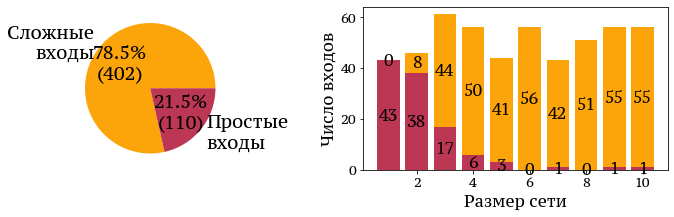

In [16]:
# Посмотрим на разбиение на простые и сложные модели
def plot_complexity_pie(df):
    fig, axes = plt.subplots(figsize=(12, 3), ncols=2, nrows=1)
    complexities_ = df.complexity.value_counts()
    simple_color = get_color(0.5)
    complex_color = get_color(0.8)
    
    complexity_trans = [
        {"complex": "Сложные\nвходы", 
         "simple": "Простые\nвходы"}.get(val, val)
        for val in complexities_.index
    ]
    # complexity_trans = complexities_.index
    
    # Слева покажем разбиение на простые и сложные системы:
    axes[0].pie(
        complexities_.values, colors=[complex_color, simple_color],
        autopct=lambda pct: "{:.1f}%\n({:d})".format(pct, int(round(pct/100.*len(DF)))),
        labels=complexity_trans, textprops={'fontsize': 18},
    )
    
    # Справа изобразим число сэмплов в зависимости от размера сети.
    # Сначала посчитаем число сэмплов.
    cnt_df = (df[['net_size', 'complexity', 'arrival']]
              .groupby(['net_size', 'complexity'], as_index=False)
              .aggregate('count')
              .rename(columns={'arrival': 'num_samples'}))
    max_net_size = cnt_df.net_size.max()
    simple_cnt_df = cnt_df[cnt_df.complexity == 'simple'][['net_size', 'num_samples']]
    complex_cnt_df = cnt_df[cnt_df.complexity == 'complex'][['net_size', 'num_samples']]    

    # Возможно, в num_simple_samples и num_complex_samples разное число элементов.
    # Чтобы изобразить из на одном графике, нужно это исправить.
    # Построим массивы, в которых i-й элемент хранит число сэмплов для размера сети i+1.
    net_sizes = np.arange(1, max_net_size + 1)
    simple_array = np.zeros(max_net_size)
    complex_array = np.zeros(max_net_size)
    for net_size in range(1, max_net_size + 1):
        simple_ = simple_cnt_df[simple_cnt_df.net_size == net_size]
        complex_ = complex_cnt_df[complex_cnt_df.net_size == net_size]
        simple_array[net_size - 1] = 0 if simple_.empty else simple_.num_samples.item()
        complex_array[net_size - 1] = 0 if complex_.empty else complex_.num_samples.item()

    p1 = axes[1].bar(net_sizes, simple_array, color=simple_color)
    p2 = axes[1].bar(net_sizes, complex_array, color=complex_color, bottom=simple_array)
    axes[1].bar_label(p1, label_type='center', fontsize=16)
    axes[1].bar_label(p2, label_type='center', fontsize=16)
    axes[1].tick_params(labelsize=13)
    axes[1].set_xlabel('Размер сети', fontsize=16)
    axes[1].set_ylabel('Число входов', fontsize=16)
    

#     fig.suptitle('Разбиение входных данных на простые и сложные системы', fontsize=18)

plot_complexity_pie(DF)
plt.show()

In [17]:
SIMPLE_NET_SIZE_MAX = 5  # Устанавливаем число, для которого есть более-менее адекватное число сэмплов

Посмотрим, что получилось. Для этого посмотрим на разброс параметров простых и сложных систем.

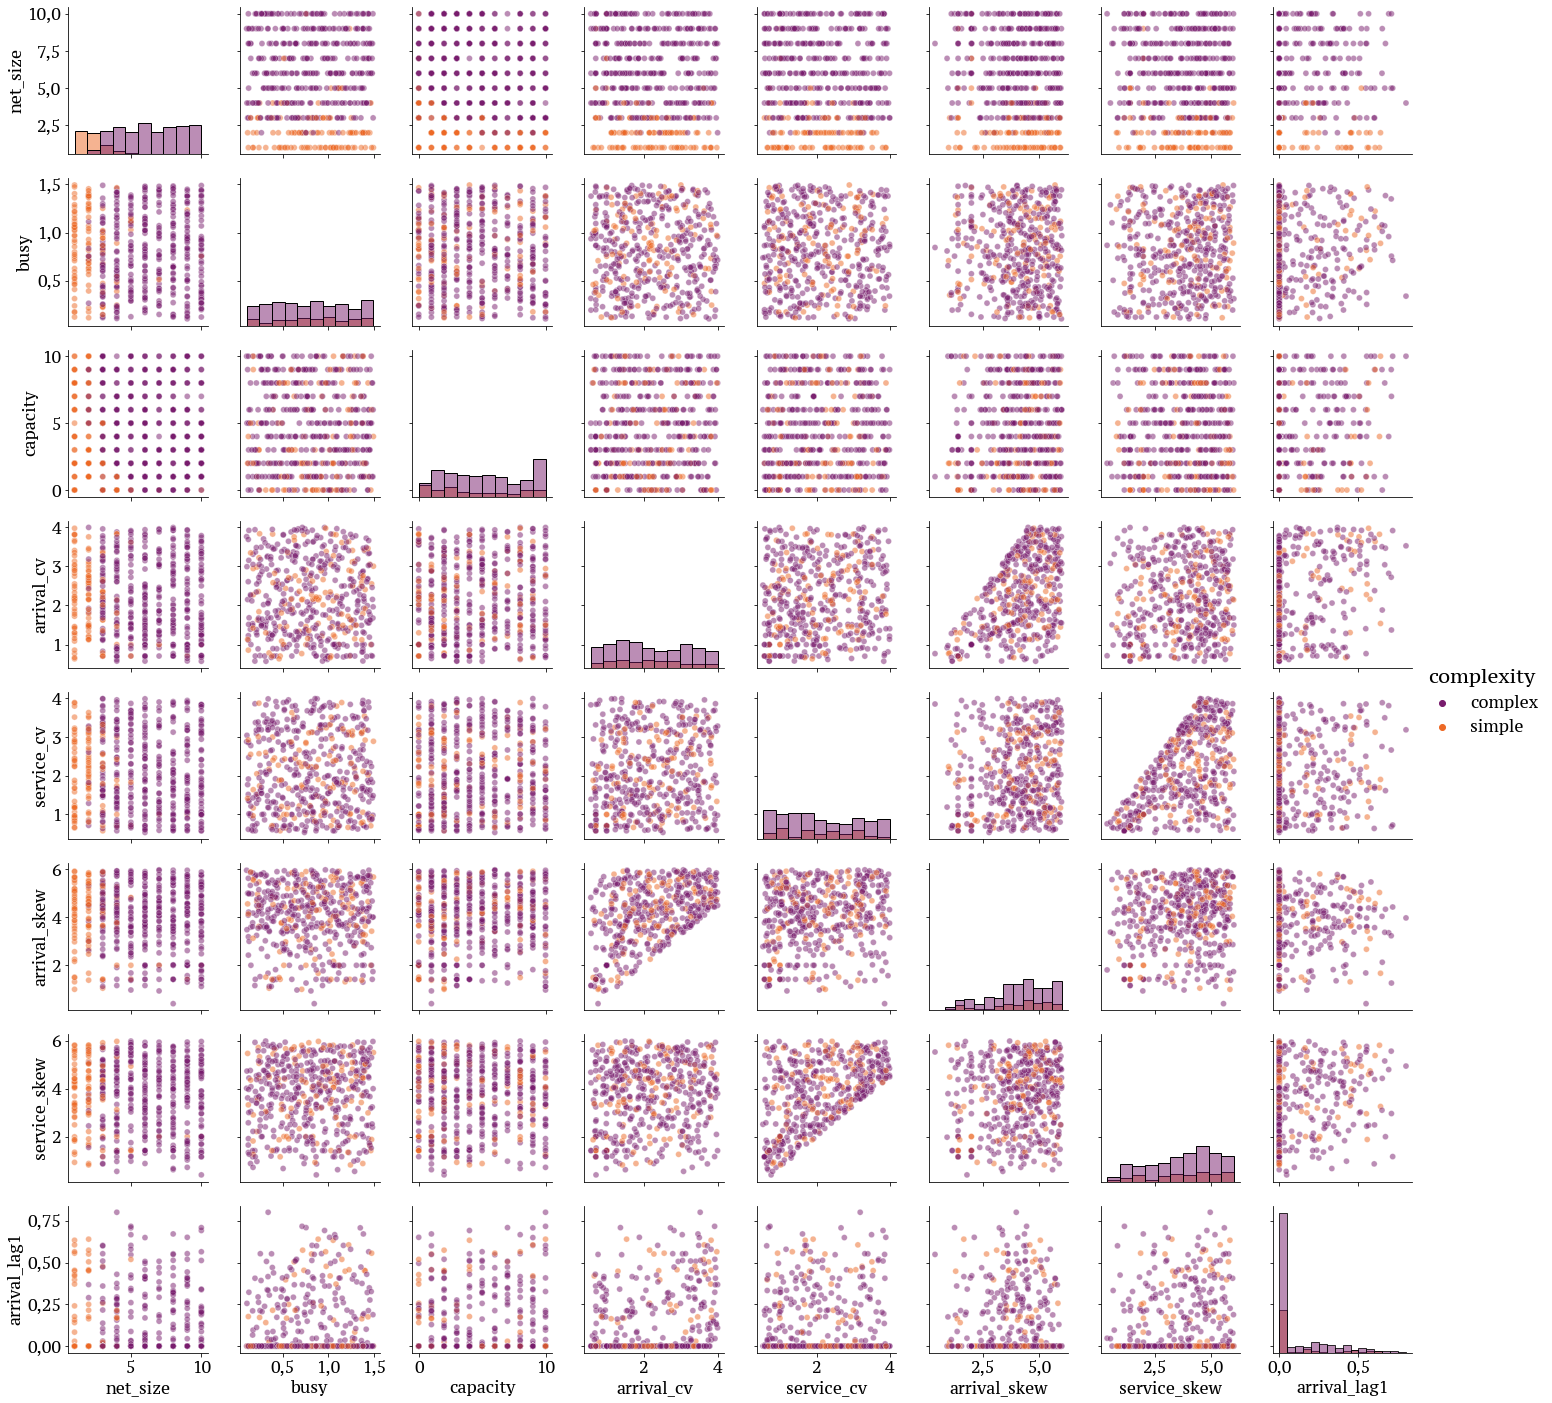

In [18]:
variables = ['net_size', 'busy', 'capacity', 'arrival_cv', 'service_cv', 
             'arrival_skew', 'service_skew', 'arrival_lag1']
g = sns.PairGrid(DF.sample(500), hue='complexity', vars=variables, 
                 palette="inferno")
g.map_diag(sns.histplot, fill=True)
g.map_offdiag(sns.scatterplot, alpha=0.5)
g.add_legend()
None

In [19]:
def _plot_input_scatter(df, axes, offset: float = 0.0, marker='o', color='black'):
    ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes
    
    scatter_kwargs = {
        'marker': marker,
        'alpha': 0.3,
        's': (df.capacity + 1)*20,
        'color': color,
    }
    
    ax1.scatter(df.net_size - 1 + offset, df.busy, **scatter_kwargs)
    ax2.scatter(df.net_size - 1 + offset, df.capacity, **scatter_kwargs)
    ax3.scatter(df.net_size - 1 + offset, df.arrival_cv, **scatter_kwargs)
    ax4.scatter(df.net_size - 1 + offset, df.service_cv, **scatter_kwargs)
    ax5.scatter(df.net_size - 1 + offset, df.arrival_skew, **scatter_kwargs)
    ax6.scatter(df.net_size - 1 + offset, df.service_skew, **scatter_kwargs)
    ax7.scatter(df.net_size - 1 + offset, df.arrival_lag1, **scatter_kwargs)
    
def plot_input_scatter(df):
    """
    Show scatter plots for inputs.
    """
    fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(18, 6), sharex=True,
                             gridspec_kw = {'height_ratios':[2,1]})
    
    color_simple = get_color(0)
    color_complex = get_color(0.66)
    
    _plot_input_scatter(df[df.complexity == 'simple'], axes[0], -0.2, marker='o', color=color_simple)
    _plot_input_scatter(df[df.complexity == 'complex'], axes[0], 0.2, marker='o', color=color_complex)
    
    columns = ['busy', 'capacity', 'arrival_cv', 'service_cv', 'arrival_skew', 
               'service_skew', 'arrival_lag1']
    
    for col, ax in zip(columns, axes[1]):
        sns.violinplot(data=df, x='net_size', y=col, hue='complexity', ax=ax, bw=.2,
                       inner="quartile", cut=True, split=True, palette={'complex': color_complex, 'simple': color_simple})
        ax.legend([], [], frameon=False)
    
    y_labels = [r'$\lambda / \mu$', 'Емкость', r'$c_a$', r'$c_s$', r'$\gamma_a$', r'$\gamma_s$', 'lag-1']
    
    for j, col_name in enumerate(columns):
        axes[0][j].set_title(col_name)
        axes[-1][j].set_xlabel('Размер сети', fontsize=14)

    for i, j in product(range(len(axes)), range(len(columns))):
        if i > 0:
            axes[i][j].grid()
        if i < len(axes) - 1:
            axes[i][j].set_xlabel('')
        axes[i][j].set_ylabel('')
    
    fig.legend(handles=[
        Line2D([0], [0], color=color_simple, lw=4, label='Сети малого размера'),
        Line2D([0], [0], color=color_complex, lw=4, label='Сети большого размера'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#555', markersize=10, lw=4, label='Маленькая емкость очереди'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='#555', markersize=20, lw=4, label='Большая емкость очереди'),
    ], bbox_to_anchor=(0.7, 0.0), fontsize=14, ncol=2)
    
    fig.suptitle("Разброс значений входных параметров", fontsize=16)

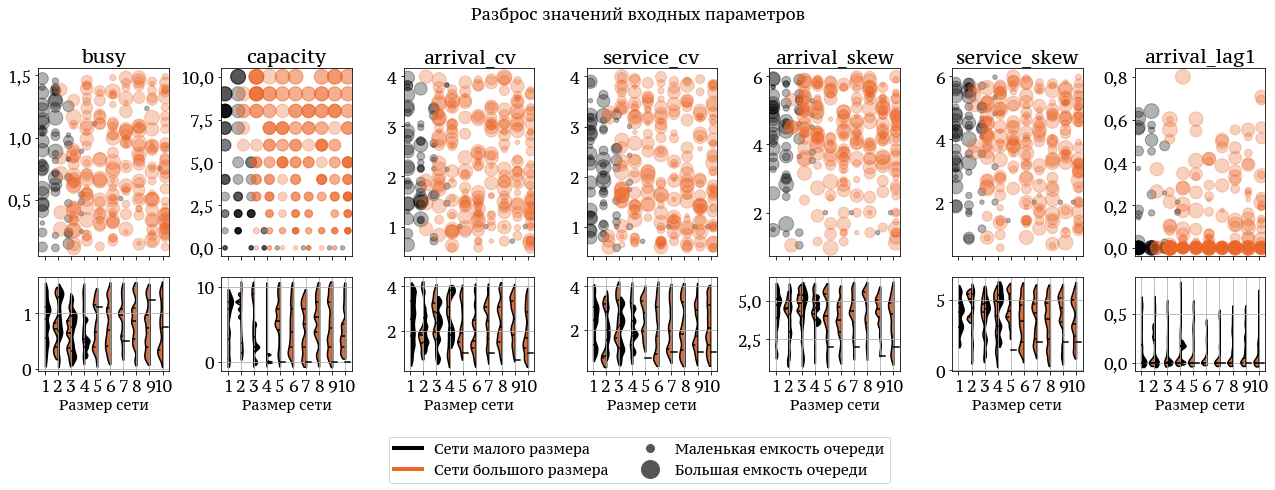

In [20]:
plot_input_scatter(DF.sample(300))
plt.tight_layout()
plt.show()

## Расчеты характеристик систем

Мы проведем несколько вариантов расчетов:

1. Точный расчет (только на тех сетях, на которых либо `small == True`, либо `intype == "basic"`)
2. Аппроксимацию выходящих потоков по трем моментам и коэффициенту автокорреляции с лагом 1
3. Аппроксимацию выходящих потоков по трем моментам без автокорреляции
4. Аппроксимацию выходящих потоков по первому моменту (то есть замену выходящих потоков Пуассоновским процессом)
5. Аппроксимацию и выходящих потоков, и входящего потока процессом Пуассона
6. Расчет с помощью метода Монте-Карло.

Заметим, что в случае (4) мы переходим от $MAP/PH/1/N$ на второй и последующих фазах к $M/PH/1/N$:
$$
\begin{aligned}
&MAP/PH/1/N \rightarrow MAP/PH/1/N \rightarrow \dots \rightarrow MAP/PH/1/N \Longrightarrow\\
&\qquad MAP/PH/1/N \rightarrow M/PH/1/N \rightarrow \dots \rightarrow M/PH/1/N
\end{aligned}
$$

А в случае (5) делаем еще более "смелую" замену:
$$
\begin{aligned}
&MAP/PH/1/N \rightarrow MAP/PH/1/N \rightarrow \dots \rightarrow MAP/PH/1/N \Longrightarrow\\
&\qquad M/PH/1/N \rightarrow M/PH/1/N \rightarrow \dots \rightarrow M/PH/1/N
\end{aligned}
$$

Для каждого метода мы будем анализировать три характеристики:

- среднюю межконцевую задержку (`delay`)
- среднюю вероятность доставки (`delivery_prob`)
- средний размер системы на последней фазе (`last_system_size`)
- сколько времени ушло на расчет (`elapsed`)

Для методов с аппроксимациями (2)-(5) также будем анализировать, насколько мы ошибаемся в оценке первых трех моментов и автокорреляции:

- максимальная ошибка в оценке среднего значения выходящего потока (`m1_err`)
- максимальная ошибка в оценке коэффициента вариации выходящего потока (`cv_err`)
- максимальная ошибка в оценке коэффициента асимметрии выходящего потока (`skew_err`)
- максимальная ошибка в оценке коэффициента автокорреляции с лагом 1 выходящего потока (`lag1_err`)

### Определение итерационной процедуры расчета

Все процедуры определены в модуле `pyqumo.algorithms.networks.mapph1n_tandem.py`. Нам понадобятся функция 
`solve_iteative()` и ее результат `SolveResults`. В следующих ячейках - их сигнатуры.

In [21]:
%pdef SolveResults

Class constructor information:
 SolveResults(
    skipped: bool,
    delay: Union[float, NoneType] = None,
    delivery_prob: Union[float, NoneType] = None,
    last_system_size: Union[float, NoneType] = None,
    elapsed: Union[float, NoneType] = None,
    max_inp_order: Union[int, NoneType] = None,
    max_out_order: Union[int, NoneType] = None,
    m1_err: Union[float, NoneType] = None,
    cv_err: Union[float, NoneType] = None,
    skew_err: Union[float, NoneType] = None,
    lag1_err: Union[float, NoneType] = None,
) -> None
 

In [22]:
%pdef solve_iterative

 solve_iterative(
    arrival: Union[pyqumo.arrivals.MarkovArrival, NoneType] = None,
    service: Union[pyqumo.random.PhaseType, NoneType] = None,
    capacity: Union[int, NoneType] = None,
    net_size: Union[int, NoneType] = None,
    reducer: Union[Callable[[pyqumo.arrivals.MarkovArrival], pyqumo.arrivals.MarkovArrival], NoneType] = None,
    reduce_arrival: bool = False,
    reduce_departure: bool = False,
    max_precise_order: int = 8000,
) -> pyqumo.algorithms.networks.mapph1n_tandem.SolveResults
 

Применять итерационную процедуру мы будем однотипно:

1. Выполняем процедуру с теми или иным аргументами `reducer` и `reduce_arrival`, результаты записываем в колонку `__solve_ret`
2. Растаскиваем результаты по отдельным колонками. У колонок будут названия с префиксами, зависящими от метода, и окончаниями такими же, как названия полей (например, `precise_delay`)
3. Удаляем служебную колонку `__solve_ret`

Названия префиксов будут:

1. `precise` - точный метод
2. `approx_map` - аппроксимация MAP-потоками (по 3 моментам и лагу)
3. `approx_ph3` - аппроксимация PH-распределениями (по 3 моментам)
4. `approx_ph1` - аппроксимация выходов потоками Пуассона
5. `approx_mm1` - аппроксимация потоками Пуассона всех входящих и выходящих процессов

> **!!! К сожалению, нельзя просто так взять, и применить алгоритм, особенно точный, к DataFrame-у из IPython (Jupyter) !!!**
>
> Если попытаться просто использовать `DataFrame.apply()`, то он не посчитает нужным освобождать память, и она, естественно, быстро кончится
(матрицы `4000x4000` к этому стимулируют).
>
> Возможное решение - использовать multiprocessing: выделяем по процессу на подсет, и применяем. А после завершения процесса его ресурсы вернутся к системе, независимо от воли garbage collector-а. 
> Но... **IPython не дает выполнять multiprocessing.Pool()**. Точнее, дает, но виснет.
>
> Единственное решение, которое я нашел - вынести расчет в отдельный скрипт, который вызывать через `%run`.
> Этот скрипт хранится в `experiments/bin/solve_mapph1n_tandem.py`.

### Точный расчет

Начнем с выполнения точного расчета.

In [23]:
PRECISE_PREFIX = 'precise'

if f'{PRECISE_PREFIX}_delay' not in DF.columns:
    %run bin/map_tandem.py solve $DATA_CSV --no-reduce-departure --prefix $PRECISE_PREFIX --timeout 30
else:
    print('[=] skipping, set FORCE_COMPUTE = True.', )

DF = load_data(DATA_CSV, create_dists=True, tol=.05)

[=] skipping, set FORCE_COMPUTE = True.


Посмотрим на то, как выглядят входные данные для точного расчета.

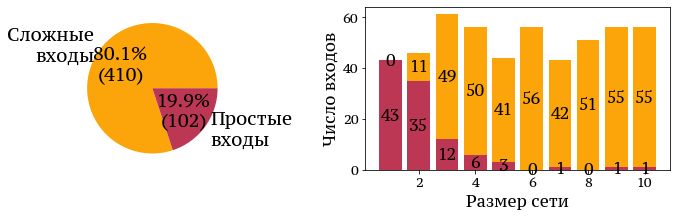

In [32]:
DF['complexity'] = DF.apply(
    lambda r: 'simple' if not r[f'{PRECISE_PREFIX}_skipped'] else 'complex',
    axis=1)
plot_complexity_pie(DF)
savefig(("ch4_complexity_split.pdf", "ch4_complexity_split.png"))

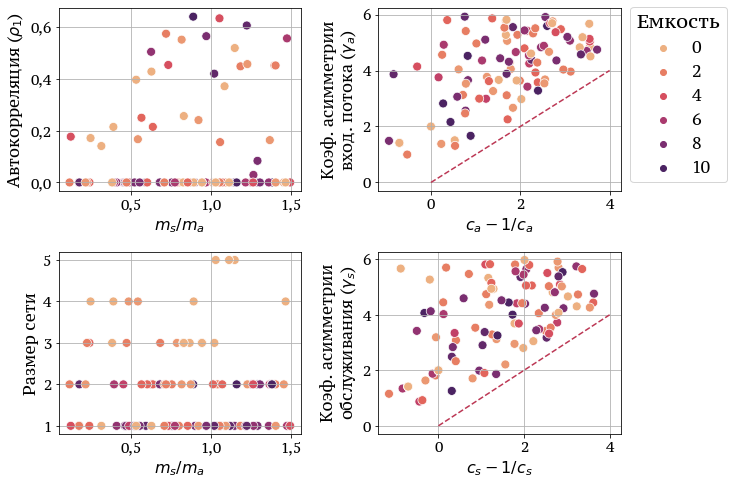

In [47]:
def plot_simple_scatter(df: pd.DataFrame, out: Union[str, Sequence[str]] = ()):
    """
    Plot scatter diagrams describing simple inputs.
    """
    df1 = df.copy()
    fig, axes = plt.subplots(figsize=(9, 7), nrows=2, ncols=2)
    ax1, ax2, ax3, ax4 = axes[0][0], axes[0][1], axes[1][0], axes[1][1]
    df1 = df1.rename(columns={'net_size': 'Размер сети',
                              'capacity': 'Емкость очереди'})
    
    sns.scatterplot(data=df1, x='busy', y='arrival_lag1', hue='Емкость очереди', 
                    palette=SCATTER_CMAP_NAME, ax=ax1, s=80)
    sns.scatterplot(data=df1, x='busy', y='Размер сети', hue='Емкость очереди', 
                    palette=SCATTER_CMAP_NAME, ax=ax3, s=80)
    
    df1['arrival cv - 1/cv'] = \
        df1.apply(lambda r: r['arrival_cv'] - 1/r['arrival_cv'], axis=1)
    
    df1['service cv - 1/cv'] = \
        df1.apply(lambda r: r['service_cv'] - 1/r['service_cv'], axis=1)
    
    sns.scatterplot(data=df1, x='arrival cv - 1/cv', y='arrival_skew', 
                    hue='Емкость очереди', palette=SCATTER_CMAP_NAME, 
                    ax=ax2, s=80)
    sns.scatterplot(data=df1, x='service cv - 1/cv', y='service_skew', 
                    hue='Емкость очереди', palette=SCATTER_CMAP_NAME, 
                    ax=ax4, s=80)
    
    ax2.plot([0, 4], [0, 4], linestyle='--', color=get_color(0.5))
    ax4.plot([0, 4], [0, 4], linestyle='--', color=get_color(0.5))
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid()
        ax.tick_params(labelsize=14)
    for ax in [ax1, ax2, ax3, ax4]:
        ax.legend([], [], frameon=False)

    ax1.set_xlabel(r'$m_s / m_a$', fontsize=16)
    ax1.set_ylabel(r'Автокорреляция ($\rho_1$)', fontsize=16)
    ax2.set_xlabel(r'$c_a - 1/c_a$', fontsize=16)
    ax2.set_ylabel('Коэф. асимметрии\n' + r'вход. потока ($\gamma_a$)', 
                   fontsize=16)
    ax4.set_xlabel(r'$c_s - 1/c_s$', fontsize=16)
    ax4.set_ylabel('Коэф. асимметрии\n' + r'обслуживания ($\gamma_s$)', 
                   fontsize=16)
    ax3.set_xlabel(r'$m_s / m_a$', fontsize=16)
    ax3.set_ylabel(r'Размер сети', fontsize=16)
    
    fig.legend(*ax1.get_legend_handles_labels(), 
               loc='center right', bbox_to_anchor=(1.15, 0.795), ncol=1,
               title="Емкость")
    
    
    plt.tight_layout()
    savefig(out)
    
plot_simple_scatter(
    DF[(DF.complexity == 'simple') & (DF.net_size <= SIMPLE_NET_SIZE_MAX)],
    out=(("ch4_input_scatter.pdf", "ch4_input_scatter.png"))
)


In [49]:
# В этой ячейке строится много диаграмм разброса для характеризации простых 
# входных данных. Можно раскоментировать, если диаграммы выше недостаточно.
# ----------------------------------------------------------------------------

# variables = ['net_size', 'busy', 'capacity', 'arrival_cv', 'service_cv', 
#              'arrival_skew', 'service_skew', 'arrival_lag1']
# g = sns.PairGrid(
#     DF[(DF.complexity == 'simple') & (DF.net_size <= SIMPLE_NET_SIZE_MAX)], 
#     vars=variables)
# g.map_diag(sns.kdeplot, fill=True, cut=True)
# g.map_offdiag(sns.scatterplot, alpha=0.5)
# g.add_legend()
# None

Определим функцию для вывода сводных данных о выполненных расчетах. Будем отражать:

- распределение межконцевых задержек
- распределение вероятностей доставки
- распределение размера системы на последней фазе
- распределение затраченного времени
- распределение ошибок приближения моментов
- распределение размеров потоков

In [92]:
def plot_solution_stats(df, prefixes, title: str = ""):
    """
    Изобразить сводные данные о выполненных расчетах.
    
    Parmeters
    ---------
    df : DataFrame
    prefixes : sequence of (prefix, label)
    """
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
    
    if isinstance(prefixes, str):
        prefixes = [(prefixes, prefixes)]
    
    # Define metric and approximation columns names:
    metrics_cols = ['skipped', 'delay', 'delivery_prob', 'last_system_size', 
                    'elapsed', 'max_inp_order', 'max_out_order']
    approx_cols = ['m1_err', 'cv_err', 'skew_err', 'lag1_err']
    approx_cols_labels = [r"$M_1$", r'$c_v$', r'$\gamma$', r'$\rho_1$']
    
    # Transform dataframe:
    chunks = []
    for prefix, label in prefixes:
        new_metrics_cols = list(metrics_cols)  # make a copy
        prefixed_metrics_cols = [f'{prefix}_{col}' for col in new_metrics_cols]
        
        new_approx_cols = \
            list(approx_cols) if f'{prefix}_m1_err' in df.columns else []
        prefixed_approx_cols = [f'{prefix}_{col}' for col in new_approx_cols] 
        
        old_cols = [*prefixed_metrics_cols, *prefixed_approx_cols]
        new_cols = [*metrics_cols, *new_approx_cols]
        
        if f'{prefix}_skipped' in df.columns:
            chunk = df[df[f'{prefix}_skipped'] == False]
        else:
            chunk = df
        
        old_cols_ = []
        new_cols_ = []
        for oc, nc in zip(old_cols, new_cols):
            if oc in df.columns:
                old_cols_.append(oc)
                new_cols_.append(nc)
        old_cols = old_cols_
        new_cols = new_cols_

        chunk = (
            chunk[[*old_cols]]
            .rename(columns={oc: nc for oc, nc in zip(old_cols, new_cols)})
            .copy())
        chunk['approximation'] = label
        chunks.append(chunk)
    
    df1 = pd.concat(chunks, ignore_index=True)
    
    fill = len(prefixes) == 1
    sns.kdeplot(ax=axes[0][0], data=df1, x='delay', fill=fill, 
                hue="approximation", palette=CMAP_NAME)
    sns.kdeplot(ax=axes[0][1], data=df1, x='delivery_prob', fill=fill, 
                hue="approximation", palette=CMAP_NAME)
    if 'last_system_size' in df1.columns:
        sns.kdeplot(ax=axes[0][2], data=df1, x='last_system_size', fill=fill, 
                    hue="approximation", palette=CMAP_NAME)
    
    df2 = pd.melt(df1[['elapsed', 'approximation']], id_vars=['approximation'])
    g0 = sns.boxplot(ax=axes[1][0], data=df2, x='variable', y='value', 
                     hue="approximation", palette=CMAP_NAME)
    axes[1][0].set_yscale('log')
    axes[1][0].set_xticklabels(["Общее время"])
    
    # To plot maximum input and output orders, melt the dataframe:
    order_metrics_cols = ['max_inp_order', 'max_out_order',]
    df2 = pd.melt(df1[[*order_metrics_cols, 'approximation']], 
                  id_vars=['approximation'])
    df2.value = df2.value.astype(float).astype('Int32')
    g1 = sns.boxplot(ax=axes[1][1], data=df2, x='variable', y='value', 
                     hue='approximation', palette=CMAP_NAME)
    axes[1][1].set_yscale('log')
    axes[1][1].set_xticklabels(["Вход", "Выход"])
    
    if 'm1_err' in df1.columns:
        df2 = pd.melt(df1[[*approx_cols, 'approximation']], 
                      id_vars=['approximation'])        
        g2 = sns.boxplot(
            ax=axes[1][2], data=df2, x="variable", y="value", fliersize=0, 
            hue="approximation", palette=CMAP_NAME)
        g2.set_xticklabels(approx_cols_labels)
        axes[1][2].set_ylim((0, df2['value'].quantile(0.999) + 0.01))
    
    axes[0][0].set_title('Распределение задержек', fontsize=14)    
    axes[0][0].set_xlabel('Задержка', fontsize=12)
    axes[0][1].set_title('Распределение вероятностей\nдоставки', fontsize=14)
    axes[0][1].set_xlabel('Вероятность доставки пакета', fontsize=12)
    axes[0][2].set_title('Распределение размеров \nсистемы на последней фазе', 
                         fontsize=14)
    axes[0][2].set_xlabel('Размер системы', fontsize=12)
    for ax in axes[0]:
        ax.set_ylabel('')
    
    axes[1][0].set_title('Время на поиск решения', fontsize=14)
    axes[1][0].set_ylabel('Время', fontsize=12)
    axes[1][1].set_title('Максимальные порядки\nMAP-потоков', fontsize=14)
    axes[1][1].set_ylabel('Число состояний', fontsize=12)
    axes[1][2].set_title('Погрешности приближений', fontsize=14)
    axes[1][2].set_ylabel('Ошибка', fontsize=12)
    for ax in axes[1]:
        ax.set_xlabel('')
        
    for ax_row in axes:
        for ax in ax_row:
            ax.legend([], [], frameon=False)
            ax.grid()
            
    fig.legend(*g0.get_legend_handles_labels(), loc='lower center',
               bbox_to_anchor=(0.5, -0.05))
    # g0.legend(bbox_to_anchor=(4.8, 2.4), fontsize=14)
    
    if title:
        fig.suptitle(title + f'\nОбъем выборки: {len(df)} точек', fontsize=16)
    fig.subplots_adjust(hspace=0.6, wspace=0.4, top=0.84)

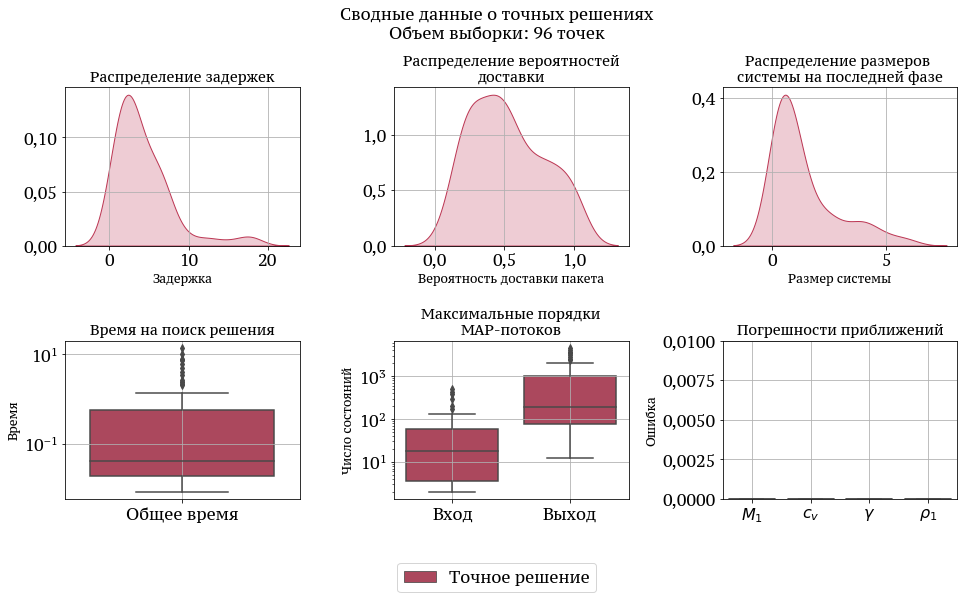

In [94]:
plot_solution_stats(
    DF[(DF.precise_skipped == False) & (DF.net_size < SIMPLE_NET_SIZE_MAX)], 
    [('precise', 'Точное решение')], 
    title="Сводные данные о точных решениях")

plt.show()

Мы будем рассматривать четыре варианта аппроксимаций:

- апрроксимацию по трем моментам и коэффициенту автокорреляции
- аппроксимацию по трем моментам и нулевой автокорреляции
- аппроксимацию по первому моменту ($M/PH/1/N$)

Во всех случаях будем рассматривать два варианта: с аппроксимацией входящих потоков и без нее.

In [95]:
WITH_ARRIVAL_SUFFIX = '_wa'

В дальнейшем нам понядобятся относительные ошибки. Определим функцию для добавления соответствующих колонок в датафрейм.

In [96]:
def add_errors_cols(
        df, 
        approximations,
        precise_prefix=PRECISE_PREFIX,
        metrics=('delay', 'delivery_prob', 'last_system_size'),
        error_suffix='error',
        approx_metrics=None) -> pd.DataFrame:
    """
    Adds columns like 'prefix_metric_suffix', where prefix is approximation prefix,
    suffix is error suffix and metric is one of the metrics.
    
    For example, if `approximations = ('approx_ph1', 'sim')`, `precise_prefix = 'precise'` and
    `metrics = ('delay',)`, then it will add columns:
    
    - `approx_ph1_delay_error`
    - `approx_sim_delay_error`
    
    And these columns will hold relative error based on `precise_delay` values.
    """
    # По-умолчанию, аппроксимированные метрики называются так же, как и точные.
    if approx_metrics is None:
        approx_metrics = metrics
    
    skipped_col = f'{precise_prefix}_skipped'
    has_skipped = skipped_col in df.columns
    
    if isinstance(approximations, str):
        approximations = [approximations]
    
    for approx_prefix in approximations:
        for precise_metric, approx_metric in zip(metrics, approx_metrics):
            p_col = f'{precise_prefix}_{precise_metric}'
            a_col = f'{approx_prefix}_{approx_metric}'
            e_col = f'{approx_prefix}_{precise_metric}_{error_suffix}'
            df[e_col] = df.apply(
                lambda data: rel_err(data[p_col], data[a_col]) if not has_skipped or not data[skipped_col] else np.nan, 
                axis=1)
    
    return df

### Анализ корреляции в выходных потоках

In [97]:
from pyqumo import MapPh1NQueue

def get_departure_lag_k(data, k):
    map_ = data.arrival
    lags = [map_.lag(1)]
    cvs = [map_.cv]
    for i in range(k):
        queue = MapPh1NQueue(map_, data.service, data.capacity)
        map_ = queue.departure
        lags.append(map_.lag(1))
        cvs.append(map_.cv)
    return lags, cvs

def get_departure_lag1(data):
    return get_departure_lag_k(data, 1)[0][1]

def get_departure_cv(data):
    return get_departure_lag_k(data, 1)[1][1]

def get_dist_group_type(data, place: str = 'arrival') -> str:
    col_name = f'{place}_cv'
    cv = data[col_name]
    if 0.95 < cv < 1.05:
        return r"$cv \approx 1$"
    if cv > 1:
        return r"$cv > 1$"
    if cv < 1:
        return r"$cv < 1$"

In [98]:
DF1 = DF[DF.precise_skipped == False].copy()
DF1['dep_lag1'] = DF1.apply(get_departure_lag1, axis=1)
DF1['dep_cv'] = DF1.apply(get_departure_cv, axis=1)
DF1['Arrival Type'] = DF1.apply(lambda r: get_dist_group_type(r, 'arrival'), axis=1)
DF1['Service Type'] = DF1.apply(lambda r: get_dist_group_type(r, 'service'), axis=1)
DF1[r'$\lambda / \mu$'] = DF1.apply(lambda r: r.busy, axis=1)
DF1 = DF1.rename(columns={
    'Arrival Type': 'Arrival',
    'Service Type': 'Service'
})

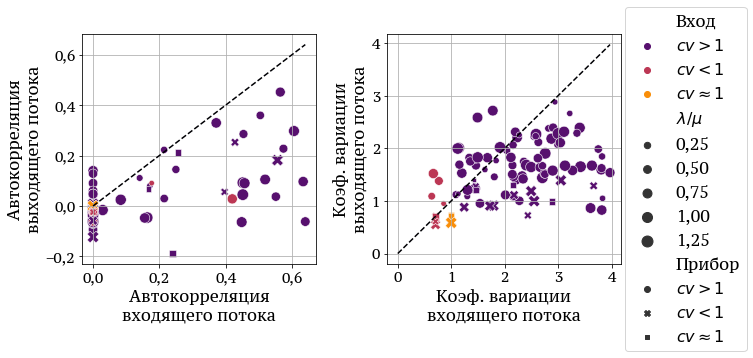

In [133]:
def plot_single_node_departure_autocorr(out: Union[str, Sequence[str]] = ()):
    fig, axes = plt.subplots(figsize=(9, 4.5), ncols=2)
    df = DF1.rename(columns={"Arrival": "Вход", "Service": "Прибор"})
    sns.scatterplot(data=df, x='arrival_lag1', y='dep_lag1', 
                    size=r'$\lambda / \mu$', hue='Вход', style='Прибор', 
                    ax=axes[0], palette=CMAP_NAME, sizes=(30, 140))
    sns.scatterplot(data=df, x='arrival_cv', y='dep_cv', 
                    size=r'$\lambda / \mu$', hue='Вход', style='Прибор',
                    ax=axes[1], palette=CMAP_NAME, sizes=(30, 140))
    
    for ax in axes:
        ax.legend([], [], frameon=False)
    
    axes[0].set_xlabel('Автокорреляция\nвходящего потока', fontsize=16)
    axes[0].set_ylabel('Автокорреляция\nвыходящего потока', fontsize=16)
    axes[1].set_xlabel('Коэф. вариации\nвходящего потока', fontsize=16)
    axes[1].set_ylabel('Коэф. вариации\nвыходящего потока', fontsize=16)
    max_lag_ = max(DF1.arrival_lag1.max(), DF1.dep_lag1.max())
    max_cv_ = max(DF1.arrival_cv.max(), DF1.dep_cv.max())
    axes[0].plot([0, max_lag_], [0, max_lag_], linestyle='--', 
                 color=get_color(0.0))
    axes[1].plot([0, max_cv_], [0, max_cv_], linestyle='--', 
                 color=get_color(0.0))
    for ax in axes:
        ax.grid()
        ax.tick_params(labelsize=14)
    
    fig.legend(*axes[0].get_legend_handles_labels(), loc='center right',
               bbox_to_anchor=(1.18, 0.5))
    plt.tight_layout()
    savefig(out)

plot_single_node_departure_autocorr(
    ('ch4_departure_autocorr.pdf', 'ch4_departure_autocorr.png'))

In [ ]:
_DF = DF[(DF.precise_skipped == False) & (DF.net_size >= 3)][['arrival', 'service', 'capacity']].copy()
data_ = {'arr_lag': [], 'dep_lag': [], 'k': [], 'arr_cv': [], 'dep_cv': [], 'busy': []}
for i, r in tqdm(_DF.iterrows(), total=len(_DF)):
    lags, cvs = get_departure_lag_k(r, 3)    
    for k in range(1, 4):
        data_['arr_lag'].append(lags[k-1])
        data_['dep_lag'].append(lags[k])
        data_['arr_cv'].append(cvs[k-1])
        data_['dep_cv'].append(cvs[k])
        data_['k'].append(k)
        data_['busy'].append(r.service.mean / r.arrival.mean)
DF2 = pd.DataFrame(data_)
del data_
del _DF

In [ ]:
if 'busy' in DF2.columns:
    DF2 = DF2.rename(columns={'busy': r'$\lambda / \mu$'})
if 'k' in DF2.columns:
    DF2 = DF2.rename(columns={'k': 'Узел'})

In [ ]:
fig, axes = plt.subplots(figsize=(12, 5), ncols=2)
sns.scatterplot(data=DF2, x='arr_lag', y='dep_lag', hue='Узел', size=r'$\lambda / \mu$', ax=axes[0], palette='Set1')
sns.scatterplot(data=DF2, x='arr_cv', y='dep_cv', hue='Узел', size=r'$\lambda / \mu$', ax=axes[1], palette='Set1')
axes[0].legend([], [], frameon=False)
axes[1].legend(loc='center right', bbox_to_anchor=(1.4, 0.5), fontsize=16)
axes[0].set_xlabel('Автокорреляция входящего потока', fontsize=16)
axes[0].set_ylabel('Автокорреляция выходящего потока', fontsize=16)
axes[1].set_xlabel('Коэф. вариации входящего потока', fontsize=16)
axes[1].set_ylabel('Коэф. вариации выходящего потока', fontsize=16)
min_lag_ = max(DF2.arr_lag.min(), DF2.dep_lag.min())
max_lag_ = max(DF2.arr_lag.max(), DF2.dep_lag.max())
min_cv_ = max(DF2.arr_cv.min(), DF2.dep_cv.min())
max_cv_ = max(DF2.arr_cv.max(), DF2.dep_cv.max())
axes[0].plot([0, max_lag_], [0, max_lag_], linestyle='--')
axes[1].plot([0, max_cv_], [0, max_cv_], linestyle='--')
for ax in axes:
    ax.grid()
    ax.tick_params(labelsize=14)
axes[0].plot([-1, 1], [-1, 1], linestyle='--', color=get_color(0))
axes[1].plot([0, 3], [0, 3], linestyle='--', color=get_color(0))
axes[0].set_xlim((-0.25, 0.4))
axes[0].set_ylim((-0.25, 0.4))
axes[1].set_xlim((0.5, 3))
axes[1].set_ylim((0.5, 3))
# plt.tight_layout()
plt.savefig('output/1a_net_departure_autocorr.pdf')

### Аппроксимация выходных потоков потоками Пуассона (PH-1)

In [ ]:
APPROX_PH1_PREFIX = 'approx_ph1'
APPROX_PH1_WITH_ARRIVAL_PREFIX = f'{APPROX_PH1_PREFIX}{WITH_ARRIVAL_SUFFIX}'

print(hl(f'[*] running approximation with Poisson '\
         f'(reduce arrival: yes, prefix: "{APPROX_PH1_WITH_ARRIVAL_PREFIX}")', 
         TextColor.OKCYAN))
if f"{APPROX_PH1_WITH_ARRIVAL_PREFIX}_delay" not in DF.columns:
    
    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure --reduce-arrival -m 1 \
        --prefix $APPROX_PH1_WITH_ARRIVAL_PREFIX 

else:    
    print('[=] skipping, set FORCE_COMPUTE = True.')

print(hl(f'[*] running approximation with Poisson '
         f'(reduce arrival: no, prefix: "{APPROX_PH1_PREFIX}")', 
         TextColor.OKCYAN))
    
if f"{APPROX_PH1_PREFIX}_delay" not in DF.columns:

    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure -m 1 \
        --prefix $APPROX_PH1_PREFIX
    
else:
    print('[=] skipping, set FORCE_COMPUTE = True.')

DF = add_errors_cols(
    load_data(DATA_CSV, create_dists=True, tol=.05), 
    approximations=[APPROX_PH1_PREFIX, APPROX_PH1_WITH_ARRIVAL_PREFIX],
    precise_prefix=PRECISE_PREFIX)

In [ ]:
#!!! NEGATIVE EXPONENTS IN PH-1 APPROXIMATIONS (without arrival approximation):
# solving for 
# net_size=10, capacity=1;
# arrival: rate=1.20877238, cv=1.0, lag=8.881784197001248e-16, D0="-0.10973501000000004, 0.0; 0.0, -1.20877238", D1="0.10973501, 4.06580919e-17; 7.29462219e-17, 1.20877238"; 
# service: rate=3.3052168666666666, cv=0.5773502691896257, S="-9.9156506, 9.9156506, 0.0; 0.0, -9.9156506, 9.9156506; 0.0, 0.0, -9.9156506", P="1.0, 0.0, 0.0"

# def reducer_(arrival):
#     (d0, d1), _ = pyqumo.matrix.fix_markovian_arrival([arrival.d0, arrival.d1], tol=.2)
#     arrival = MarkovArrival(d0, d1)
#     print(arrival.d0 + arrival.d1)

#     print("--- reduction ----")
#     print("D0:")
#     print(np.array2string(arrival.d0, formatter={'float': lambda x: f"{x:.3f}"}, max_line_width=120))
#     print("D1:")
#     print(np.array2string(arrival.d1, formatter={'float': lambda x: f"{x:.3f}"}, max_line_width=120))
#     print('Mean: ', arrival.moment(1))
    
#     return reduce_map(arrival, num_moments=1, use_lag=False)
# solve_iterative(arrival=row.arrival, service=row.service, net_size=row.net_size, capacity=row.capacity, reducer=reducer_, reduce_departure=True)


In [ ]:
plot_solution_stats(DF[DF.precise_skipped == False], prefixes=[
    (PRECISE_PREFIX, 'Точное решение'),
    (APPROX_PH1_WITH_ARRIVAL_PREFIX, 'Аппроксимация\nи выходящих,\nи входящего потоков'), 
    (APPROX_PH1_PREFIX, 'Аппроксимация\nтолько выходящих\nпотоков'),
], title='Приближение MAP-потоков потоками Пуассона (PH-1)')

Теперь посмотрим на ошибку приближения.

In [ ]:
def plot_approx_scatters_of(
        df: pd.DataFrame, 
        prefix: str, 
        title: str = "", 
        precise_prefix: str = PRECISE_PREFIX,
        max_net_size: int = 0,
        axes=None,
        show_legend=False,
        xname='точное значение',
        yname='аппроксимация',
        legend_x=0.6,
        legend_y=-0.8):
    """
    Изобразить отклонения решений.
    """
    metrics = ['delay', 'delivery_prob', 'last_system_size']
    labels = ['Задержка', 'Вероятность\nдоставки', 'Размер последней\nсистемы']
    
    approx_skipped_col = f'{prefix}_skipped'
    precise_skipped_col = f'{precise_prefix}_skipped'
    
    # Отбираем только те строки, в которых есть данные:
    if approx_skipped_col in df.columns:
        df = df[df[approx_skipped_col] == False]
    if precise_skipped_col in df.columns:
        df = df[df[precise_skipped_col] == False]
    
    # Игнорируем записи про размер сети, больший, чем указано:
    if max_net_size > 0:
        df = df[df.net_size <= max_net_size]
    
    if axes is None:
        _, axes = plt.subplots(figsize=(len(metrics) * 4, 4), nrows=1, ncols=len(metrics), sharex=True)
    g = [None] * len(metrics)
    for i, metric in enumerate(metrics):
        approx_col = f'{prefix}_{metric}'
        precise_col = f'{precise_prefix}_{metric}'
        g[i] = sns.scatterplot(ax=axes[i], data=df, x=precise_col, y=approx_col, size='net_size', hue='net_size')
    for ax in axes:
        ax.legend([], [], frameon=False)
    
    if show_legend:
        axes[1].legend(loc='lower center', bbox_to_anchor=(legend_x, legend_y), 
                       fontsize=16, ncol=df.net_size.max(),
                       title_fontsize=16)
        g[1].axes.get_legend().set_title('Размер сети')        
    
    for i, ax in enumerate(axes):
        ax.grid()
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([0, max_val], [0, max_val], linestyle='--')
        if show_legend:
            ax.set_xlabel(labels[i] + f'\n({xname})', fontsize=16)
        if not show_legend:
            ax.set_xlabel('', fontsize=16)
        ax.set_ylabel(labels[i] + f'\n({yname})', fontsize=16)
        ax.tick_params(labelsize=14)
    if title:
        axes[1].set_title(title, fontsize=16)

Более наглядно погрешность можно увидеть на диаграммах разброса.

In [ ]:
fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=3)

plot_approx_scatters_of(DF, APPROX_PH1_WITH_ARRIVAL_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                       title='Аппроксимация всех узлов системами M/PH/1/N',
                       axes=axes[0])

plot_approx_scatters_of(DF, APPROX_PH1_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                       title='Аппроксимация выходящих потоков Пуассоновскими потоками',
                       axes=axes[1], show_legend=True)
plt.tight_layout()
plt.savefig('output/1a_scatter_ph1.pdf')

In [ ]:
def plot_approx_errors_of(
        df: pd.DataFrame, 
        prefix: str, 
        title: str = "", 
        limit_y: bool = False, 
        precise_prefix: str = PRECISE_PREFIX, 
        approx_col_map: Optional[Dict[str, str]] = None,
        max_net_size: int = 0):
    """
    Отобразить ошибки по каждой из метрик. Сравнение производится с колонками `{precise_prefix}_xxx`
    (например, `precise_delay` или `approx_map_delay`, если `precise_prefix = "approx_map"`).
    
    Если указан `limit_y = True`, то ось OY будет ограничена сверху единицей.
    
    Аргумент `approx_col_map` может содержать словарь `метрика -> колонка` (без префиксов).
    Если он указан, то вместо ошибки из колонки типа `approx_ph3_delay_error` будет рассчитываться
    новая колонка ошибок, при этом для значения метрики будет использоваться колонка, указанная в
    `approx_col_map`. Например, если `approx_col_map['delay'] = 'correct_delay'`, то при вычислении 
    значения ошибки будет использоваться значение `approx_ph3_correct_delay` вместо `approx_ph3_delay`.
    """
    metrics = ['delay', 'delivery_prob', 'last_system_size']
    approx_skipped_col = f'{prefix}_skipped'
    precise_skipped_col = f'{precise_prefix}_skipped'
    
    # Отбираем только те строки, в которых есть данные:
    if approx_skipped_col in df.columns:
        df = df[df[approx_skipped_col] == False]
    if precise_skipped_col in df.columns:
        df = df[df[precise_skipped_col] == False]

    # Игнорируем записи про размер сети, больший, чем указано:
    if max_net_size > 0:
        df = df[df.net_size <= max_net_size]
        
    fig, axes = plt.subplots(figsize=(16, len(metrics) * 3), nrows=len(metrics), ncols=5, sharey=True)
    for i, metric in enumerate(metrics):
        if approx_col_map is None or metric not in approx_col_map:
            err_col = f'{prefix}_{metric}_error'
        else:
            err_col = f'_{metric}_error'
            approx_col = f'{prefix}_{metric}'
            precise_col = f'{precise_prefix}_{metric}'
            df[err_col] = df.apply(lambda r: abs((r[approx_col] - r[precise_col]) / r[precise_col]), axis=1)
        
        sns.boxplot(data=df, x='net_size', y=err_col, ax=axes[i][0])
        sns.scatterplot(data=df, x='arrival_cv', y=err_col, hue='net_size', ax=axes[i][1])
        sns.scatterplot(data=df, x='busy', y=err_col, hue='net_size', ax=axes[i][2], size="net_size")
        sns.scatterplot(data=df, x='arrival_lag1', y=err_col, hue='net_size', ax=axes[i][3], size="net_size")
        sns.scatterplot(data=df, x='capacity', y=err_col, hue='net_size', ax=axes[i][4], size="net_size")
    for ax_row in axes:
        for ax in ax_row:
            if limit_y:
                ax.set_ylim((0, 1))
            ax.grid()
    if title:
        fig.suptitle(title, fontsize=16)
    fig.subplots_adjust(hspace=0.3)

In [ ]:
plot_approx_errors_of(DF, APPROX_PH1_WITH_ARRIVAL_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксимации всех узлов системами M/PH/1/N")
plot_approx_errors_of(DF, APPROX_PH1_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксмации выходящих потоков Пуассоновскими потоками")

### Замена выходящих потоков PH-распределениями по двум моментам (PH-2)

In [ ]:
APPROX_PH2_PREFIX = 'approx_ph2'
APPROX_PH2_WITH_ARRIVAL_PREFIX = f'{APPROX_PH2_PREFIX}{WITH_ARRIVAL_SUFFIX}'

print(hl(f'[*] running approximation with Poisson '\
         f'(reduce arrival: yes, prefix: "{APPROX_PH2_WITH_ARRIVAL_PREFIX}")', 
         TextColor.OKCYAN))
if f"{APPROX_PH2_WITH_ARRIVAL_PREFIX}_delay" not in DF.columns:
    
    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure --reduce-arrival -m 2 \
        --prefix $APPROX_PH2_WITH_ARRIVAL_PREFIX 

else:    
    print('[=] skipping, set FORCE_COMPUTE = True.')

print(hl(f'[*] running approximation with Poisson '
         f'(reduce arrival: no, prefix: "{APPROX_PH2_PREFIX}")', 
         TextColor.OKCYAN))
    
if f"{APPROX_PH2_PREFIX}_delay" not in DF.columns:

    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure -m 2 \
        --prefix $APPROX_PH2_PREFIX
    
else:
    print('[=] skipping, set FORCE_COMPUTE = True.')

DF = add_errors_cols(
    load_data(DATA_CSV, create_dists=True, tol=.05), 
    approximations=[
        APPROX_PH1_PREFIX, APPROX_PH1_WITH_ARRIVAL_PREFIX,
        APPROX_PH2_PREFIX, APPROX_PH2_WITH_ARRIVAL_PREFIX,
    ],
    precise_prefix=PRECISE_PREFIX)

In [ ]:
plot_solution_stats(DF[DF.precise_skipped == False], prefixes=[
    (PRECISE_PREFIX, 'Точное решение'),
    (APPROX_PH2_WITH_ARRIVAL_PREFIX, 'Аппроксимация\nи выходящих,\nи входящего потоков'), 
    (APPROX_PH2_PREFIX, 'Аппроксимация\nтолько выходящих\nпотоков'),
], title='Приближение MAP-потоков PH по двум моментам (PH-2)')

In [ ]:
fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=3)

plot_approx_scatters_of(DF, APPROX_PH2_WITH_ARRIVAL_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                        title="Аппроксимация входящих и выходящих потоков PH-потоками по двум моментам",
                        axes=axes[0], show_legend=False)
plot_approx_scatters_of(DF, APPROX_PH2_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                        title="Аппроксимация только выходящих потоков PH-потоками по двум моментам",
                        axes=axes[1], show_legend=True)

plt.tight_layout()
plt.savefig('output/1a_scatter_ph2.pdf')

In [ ]:
plot_approx_errors_of(DF, APPROX_PH2_WITH_ARRIVAL_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксимации всех узлов системами PH(2)/PH/1/N")
plot_approx_errors_of(DF, APPROX_PH2_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксмации выходящих PH-распределениями по двум моментам")

#### Замена выходящих MAP по трем моментам

In [ ]:
APPROX_PH3_PREFIX = 'approx_ph3'
APPROX_PH3_WITH_ARRIVAL_PREFIX = f'{APPROX_PH3_PREFIX}{WITH_ARRIVAL_SUFFIX}'

print(hl(f'[*] running approximation with PH with 3 moments '\
         f'(reduce arrival: yes, prefix: "{APPROX_PH3_WITH_ARRIVAL_PREFIX}")', 
         TextColor.OKCYAN))
if f"{APPROX_PH3_WITH_ARRIVAL_PREFIX}_delay" not in DF.columns:
    
    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure --reduce-arrival -m 3 \
        --prefix $APPROX_PH3_WITH_ARRIVAL_PREFIX 

else:    
    print('[=] skipping, set FORCE_COMPUTE = True.')

print(hl(f'[*] running approximation with PH with 3 moments '
         f'(reduce arrival: no, prefix: "{APPROX_PH3_PREFIX}")', 
         TextColor.OKCYAN))
    
if f"{APPROX_PH3_PREFIX}_delay" not in DF.columns:

    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure -m 3 \
        --prefix $APPROX_PH3_PREFIX
    
else:
    print('[=] skipping, set FORCE_COMPUTE = True.')

DF = add_errors_cols(
    load_data(DATA_CSV, create_dists=True, tol=.05), 
    approximations=[
        APPROX_PH1_PREFIX, APPROX_PH1_WITH_ARRIVAL_PREFIX,
        APPROX_PH2_PREFIX, APPROX_PH2_WITH_ARRIVAL_PREFIX,
        APPROX_PH3_PREFIX, APPROX_PH3_WITH_ARRIVAL_PREFIX,
    ],
    precise_prefix=PRECISE_PREFIX)

In [ ]:
plot_solution_stats(DF[DF.precise_skipped == False], prefixes=[
    (PRECISE_PREFIX, 'Точное решение'),
    (APPROX_PH3_WITH_ARRIVAL_PREFIX, 'Аппроксимация\nи выходящих,\nи входящего потоков'), 
    (APPROX_PH3_PREFIX, 'Аппроксимация\nтолько выходящих\nпотоков'),
], title='Приближение MAP-потоков PH по трем моментам (PH-3)')

In [ ]:
fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=3)

plot_approx_scatters_of(DF, APPROX_PH3_WITH_ARRIVAL_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                        title="Аппроксимация входящих и выходящих потоков PH-потоками по трем моментам",
                        axes=axes[0])
plot_approx_scatters_of(DF, APPROX_PH3_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                        title="Аппроксимация только выходящих потоков PH-потоками по трем моментам",
                        axes=axes[1], show_legend=True)

plt.tight_layout()
plt.savefig('output/1a_scatter_ph3.pdf')

In [ ]:
plot_approx_errors_of(DF, APPROX_PH3_WITH_ARRIVAL_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксимации всех узлов системами PH(3)/PH/1/N")
plot_approx_errors_of(DF, APPROX_PH3_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксмации выходящих PH-распределениями по трем моментам")

#### Замена выходящих MAP по трем моментам и коэффициенту автокорреляции с лагом 1

In [ ]:
APPROX_MAP_PREFIX = 'approx_map'
APPROX_MAP_WITH_ARRIVAL_PREFIX = f'{APPROX_MAP_PREFIX}{WITH_ARRIVAL_SUFFIX}'

print(hl(f'[*] running approximation with MAPs with 3 moments and lag-1 autocorr. '\
         f'(reduce arrival: yes, prefix: "{APPROX_MAP_WITH_ARRIVAL_PREFIX}")', 
         TextColor.OKCYAN))
if f"{APPROX_MAP_WITH_ARRIVAL_PREFIX}_delay" not in DF.columns:
    
    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure --reduce-arrival -m 3 --use-lag \
        --prefix $APPROX_MAP_WITH_ARRIVAL_PREFIX 

else:    
    print('[=] skipping, set FORCE_COMPUTE = True.')

print(hl(f'[*] running approximation with MAPs with 3 moments and lag-1 autocorr. '\
         f'(reduce arrival: no, prefix: "{APPROX_MAP_PREFIX}")', 
         TextColor.OKCYAN))
    
if f"{APPROX_MAP_PREFIX}_delay" not in DF.columns:

    %run bin/map_tandem.py solve $DATA_CSV \
        --reduce-departure -m 3 --use-lag \
        --prefix $APPROX_MAP_PREFIX --timeout 60 --verbose 1
    
else:
    print('[=] skipping, set FORCE_COMPUTE = True.')

DF = add_errors_cols(
    load_data(DATA_CSV, create_dists=True, tol=.05), 
    approximations=[
        APPROX_PH1_PREFIX, APPROX_PH1_WITH_ARRIVAL_PREFIX,
        APPROX_PH2_PREFIX, APPROX_PH2_WITH_ARRIVAL_PREFIX,
        APPROX_PH3_PREFIX, APPROX_PH3_WITH_ARRIVAL_PREFIX,
        APPROX_MAP_PREFIX, APPROX_MAP_WITH_ARRIVAL_PREFIX,
    ],
    precise_prefix=PRECISE_PREFIX)

In [ ]:
plot_solution_stats(DF[DF.precise_skipped == False], prefixes=[
    (PRECISE_PREFIX, 'Точное решение'),
    (APPROX_MAP_WITH_ARRIVAL_PREFIX, 'Аппроксимация\nи выходящих,\nи входящего потоков'), 
    (APPROX_MAP_PREFIX, 'Аппроксимация\nтолько выходящих\nпотоков'),
], title='Приближение MAP-потоков MAP-ами по трем моментам и коэф. автокорреляции с лагом 1')

In [ ]:
# fig, ax = plt.subplots(figsize=(8, 8))
approx_map_lag1_err = DF[DF.precise_skipped == False].approx_map_lag1_err
approx_map_lag1_err.describe()

In [ ]:
fig, axes = plt.subplots(figsize=(16, 8), nrows=2, ncols=3)

plot_approx_scatters_of(DF, APPROX_MAP_WITH_ARRIVAL_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                        title="Аппроксимация входящих и выходящих потоков MAP-потоками по трем моментам и автокорр.",
                        axes=axes[0])
plot_approx_scatters_of(DF, APPROX_MAP_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX,
                        title="Аппроксимация только выходящих потоков MAP-потоками по трем моментам и автокорр.",
                        axes=axes[1], show_legend=True)

plt.tight_layout()
plt.savefig('output/1a_scatter_map.pdf')

In [ ]:
plot_approx_errors_of(DF, APPROX_MAP_WITH_ARRIVAL_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксимации всех узлов системами MAP/PH/1/N")
plot_approx_errors_of(DF, APPROX_MAP_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью аппроксмации выходящих потоков MAP-потоками по трем моментам")

### Вычисление характеристик системы с помощью метода Монте-Карло

In [ ]:
SIM_PREFIX = 'sim'

if f'{SIM_PREFIX}_delay' not in DF.columns or FORCE_COMPUTE:
    
    %run bin/map_tandem.py simulate $DATA_CSV --prefix sim --max-packets $MAX_PACKETS -j $NUM_PROCESSORS
    DF = load_data(DATA_CSV, create_dists=True, tol=.05)
    
else:
    print('[=] skipping, set FORCE_COMPUTE = True.')

DF = add_errors_cols(
    load_data(DATA_CSV, create_dists=True, tol=.05), 
    approximations=[
        APPROX_PH1_PREFIX, APPROX_PH1_WITH_ARRIVAL_PREFIX,
        APPROX_PH2_PREFIX, APPROX_PH2_WITH_ARRIVAL_PREFIX,
        APPROX_PH3_PREFIX, APPROX_PH3_WITH_ARRIVAL_PREFIX,
        APPROX_MAP_PREFIX, APPROX_MAP_WITH_ARRIVAL_PREFIX,
        SIM_PREFIX,
    ],
    precise_prefix=PRECISE_PREFIX)

In [ ]:
plot_solution_stats(DF[DF.precise_skipped == False], prefixes=[
    (PRECISE_PREFIX, 'Точное решение'),
    (SIM_PREFIX, 'Метод Монте-Карло'), 
], title='Имитационное моделирование (метод Монте-Карло)')

In [ ]:
fig, axes = plt.subplots(figsize=(16, 4), ncols=3)
plot_approx_scatters_of(DF, SIM_PREFIX, max_net_size=SIMPLE_NET_SIZE_MAX, precise_prefix=PRECISE_PREFIX,
#                         title="Разброс оценок, полученных с помощью имитационного моделирования", show_legend=True,
                        yname='Монте-Карло',
                        axes=axes, show_legend=True)
plt.tight_layout()
plt.savefig('output/1a_scatter_monte_carlo.pdf')

In [ ]:
plot_approx_errors_of(DF, SIM_PREFIX, limit_y=True, max_net_size=SIMPLE_NET_SIZE_MAX,
                      title="Ошибки оценок, полученных с помощью Монте-Карло")

In [ ]:
fig, axes = plt.subplots(figsize=(20, 4), ncols=3)

plot_approx_scatters_of(DF, APPROX_PH3_PREFIX, precise_prefix=SIM_PREFIX,
#                         title="Сравнение оценок, полученных методами Монте-Карло и аппроксимацией выходящих потоков по трем моментам",
                        xname='Монте-Карло', yname='аппроксимация',
                        axes=axes, show_legend=True, legend_y=-.9)
plt.tight_layout()
plt.savefig('output/1a_scatter_monte_carlo_vs_ph3.pdf')

In [ ]:
plot_approx_errors_of(DF, APPROX_PH3_PREFIX, limit_y=True, precise_prefix=SIM_PREFIX,
                      title="Ошибки оценок, полученных с помощью Монте-Карло (вся выборка)")

In [ ]:
def plot_all_approx_errors(
        df, 
        metrics, 
        methods, 
        labels,
        max_err=None, 
        max_size=None):
    """
    Plot summary about errors on different methods.
    
    methods: (label, [(prefix1, description2), (prefix2, description2), ...])
    """
    # If separate, plot each method in separate ax:
    fig, axes = plt.subplots(figsize=(20, len(methods) * 3.0), 
                             nrows=len(methods), ncols=len(metrics), sharex=True)
        
    # Ограничиваем размер сети:
    if max_size is not None:
        df = df[df.net_size <= max_size]
        
    # Будем строить графики для каждой метрики и для каждого метода.
    for i in range(len(methods)):
        method = methods[i]
        method_label = method[0]
        if len(method) == 2:
            prefixes = method[1]
        # Если метод задан как `(label, prefix, index)`, а не `(label, [(prefix, index), ...])`,
        # то заполним prefixes:
        elif len(method) == 3:
            prefixes = [(method[1], method[2])]
        else:
            raise ValueError("tuple of length 2 or 3")
            
        # Теперь точно список [(prefix, description), ...].
        # Строим таблицу с записями вида `delay_error`, `delivery_prob_error`
        # и колонкой `approximation`.
        chunks = []
        for prefix, legend_index in prefixes:
            
            old_columns = [f'{prefix}_{metric}_error' for metric, _ in metrics]
            new_columns = [f'{metric}_error' for metric, _ in metrics]
            chunk = (df[['net_size', *old_columns]]
                     .rename(columns={oc: nc for oc, nc in zip(old_columns, new_columns)})
                     .copy())
            chunk['approximation'] = legend_index
            chunks.append(chunk)
        df1 = pd.concat(chunks, ignore_index=True)
        
        # Выбираем макс. значение для строки:
        y_max = None
        if max_err is not None:
            if isinstance(max_err, float) or isinstance(max_err, int):
                y_max = max_err
            else:
                y_max = max_err[i] if len(max_err) > i else 1.0
        y_max = y_max or 1.0
        
        colors = [LIGHT_CMAP(li) for _, li in prefixes]
        
        # Теперь у нас есть таблица с полями `net_size`, `xxx_error`*, `approximation`.
        # Для каждой метрики `xxx` можем построить график.
        for j, (metric, _) in enumerate(metrics):
            ax = axes[i][j] if len(methods) > 1 else axes[j]
            target = f'{metric}_error'
            sns.boxplot(ax=ax, x='net_size', y=target, hue='approximation', data=df1, 
                        palette=colors, 
                        showmeans=True,
                        meanprops={
                            'markerfacecolor': 'firebrick',
                            'markeredgecolor': 'black',
                            'marker': 'D', 'markersize': 10})
            ax.set_ylim((0, y_max))
            ax.grid()
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.legend([], [], frameon=False)
        
        axes[i][0].set_ylabel(method_label, fontsize=22)
    
    for j, (metric, metric_title) in enumerate(metrics):
        axes[0][j].set_title(metric_title, fontsize=24)
        axes[-1][j].set_xlabel('Размер сети', fontsize=22)
    
    for axes_ in axes:
        for ax in axes_:
            ax.tick_params(axis='both', which='major', labelsize=20)
            ax.tick_params(axis='both', which='minor', labelsize=18)

    fig.legend(handles=[*[Line2D([0], [0], color=get_color(li), lw=4, label=label) for li, label in labels.items()], 
                        Line2D([0], [0], marker='D', color='w', label='Среднее значение', 
                               markerfacecolor='firebrick', markeredgecolor='black', markersize=6)], 
               bbox_to_anchor=(0.85, 0.01), fontsize=22, ncol=2)
                
# Plotting:
plot_all_approx_errors(
    DF[DF.precise_skipped == False],
    [
        ('delay', "Ошибка оценки\nсуммарной задержки"), 
        ('delivery_prob', "Ошибка оценки\nвероятности доставки"),
        ('last_system_size', "Ошибка оценки размера\nсисетмы на последней фазе")
    ], 
    methods=[
        ('Аппрокс. PH\n' + r'$\mathbb{E}X$ (Пуассон)', [
            (APPROX_PH1_PREFIX, 0), 
            (APPROX_PH1_WITH_ARRIVAL_PREFIX, 1)
        ]),
        ('Аппрокс. PH\n' + r'$\mathbb{E}X$ и $cv$', [
            (APPROX_PH2_PREFIX, 0), 
            (APPROX_PH2_WITH_ARRIVAL_PREFIX, 1)
        ]),
        ('Аппрокс. PH\n' + r'$\mathbb{E}X$, $cv$, $\gamma$', [
            (APPROX_PH3_PREFIX, 0), 
            (APPROX_PH3_WITH_ARRIVAL_PREFIX, 1)
        ]),
        ('Аппрокс. MAP\n' + r'по $\mathbb{E}X$, $cv$, $\gamma$, $\rho_1$', [
            (APPROX_MAP_PREFIX, 0), 
            (APPROX_MAP_WITH_ARRIVAL_PREFIX, 1)
        ]),
        ('Монте-Карло', SIM_PREFIX, 2)
    ],
    labels={
        0: 'Аппроксимация только выходящих потоков',
        1: 'Аппроксимация и входящих, и выходящих потоков',
        2: 'Метод Монте-Карло'
    },
    max_err=[1.45, 1.0, 0.3, 0.3, 0.05],
    max_size=SIMPLE_NET_SIZE_MAX,
)
plt.tight_layout()
plt.savefig('output/1a_approximations_summary.pdf', bbox_inches = "tight")

In [ ]:
def plot_all_approx_errors_joined(df, metrics, methods, max_err=None, labels=None):
    # Prepare data: transform DF into a new dataframe with columns
    #     'net_size', 'xxx_error', 'approximation',
    # where 'xxx' is a metric (e.g., delay), 'approximation' holds the method.
    chunks = []
    for method, label in methods:
        err_cols = [f'{method}_{metric}_error' for metric in metrics]
        chunk = df[['net_size', *err_cols]].rename(columns={c: f'{metric}_error' for c, metric in zip(err_cols, metrics)}).copy()
        chunk['approximation'] = label.replace('\n', ' ')
        chunks.append(chunk)

    df1 = pd.concat(chunks, ignore_index=True)
        
    # Plot:
    fig, axes = plt.subplots(figsize=(len(metrics)*5, 3), ncols=len(metrics))
    for i, metric in enumerate(metrics):
        ax = axes[i]
        g = sns.boxplot(data=df1, x='net_size', y=f'{metric}_error', hue='approximation', ax=ax, palette='Dark2')
        ax.legend([], [], frameon=False)
        ax.grid()
        ax.set_title(labels[i].replace('\n', ' '), fontsize=14)
        ax.set_ylabel('')
        ax.set_xlabel('Размер сети', fontsize=14)
        if max_err is not None and len(max_err) > i:
            ax.set_ylim((0, max_err[i]))
    g.legend(bbox_to_anchor=(1.0, -0.2), fontsize=14, ncol=2)
            
# Plotting:
plot_all_approx_errors_joined(
    DF[(DF.precise_skipped == False) & (DF.net_size < SIMPLE_NET_SIZE_MAX)],
    ['delay', 'delivery_prob', 'last_system_size'], 
    methods=[
        ('approx_ph1', 'Экспоненциальное\nраспределение'),
        ('approx_ph2', 'PH по\nдвум моментам'),
        ('approx_ph3', 'PH по\nтрем моментам'),
        ('approx_map', 'MAP по трем\nмоментам и автокорреляции'),
        ('sim', 'Монте-Карло')
    ],
    max_err=[0.15, 0.5, 0.6],
    labels=['Ошибка оценки\nзадержки', 'Ошибка оценки\nвероятности\nдоставки', 'Ошибка оценки\nразмера системы'],
)

In [ ]:
def plot_elapsed_joined(df, methods, max_time=None, labels=None, max_net_size=None):
    # Prepare data: transform DF into a new dataframe with columns
    #     'net_size', 'elapsed', 'approximation'
    # where 'approximation' is approximation method.
    if max_net_size is not None:
        df = df[df.net_size <= max_net_size]
    chunks = []
    for method, label in methods:
        cur_elapsed_col = f'{method}_elapsed'
        chunk = (df[['net_size', cur_elapsed_col]]
                 .rename(columns={cur_elapsed_col: 'elapsed'})
                 .copy())
        if method == PRECISE_PREFIX:
            chunk = chunk[chunk.net_size <= SIMPLE_NET_SIZE_MAX].copy()
        chunk['approximation'] = label
        chunks.append(chunk)

    df1 = pd.concat(chunks, ignore_index=True)

    # Plot:
    fig, ax = plt.subplots(figsize=(10, 3.8))
    g = sns.lineplot(data=df1, x='net_size', y=f'elapsed', hue='approximation', ax=ax, palette='Set2')
    ax.legend([], [], frameon=False)
    ax.grid()
    ax.set_yscale('log')
    ax.set_ylabel('Время', fontsize=14)
    ax.set_xlabel('Размер сети', fontsize=14)
    g.legend(bbox_to_anchor=(1.0, 1), fontsize=14)

# Plotting:
plot_elapsed_joined(
    DF,
    methods=[
        ('precise', 'Точное решение'),
        ('sim', 'Монте-Карло'),
        ('approx_map', 'MAP по трем\nмоментам и\nавтокорреляции'),
        ('approx_ph3', 'PH по трем\nмоментам'),
        ('approx_ph2', 'PH по двум\nмоментам'),
        ('approx_ph1', 'Экспоненциальное\nраспределение'),
    ],
    labels=['Ошибка оценки\nзадержки', 'Ошибка оценки\nвероятности\nдоставки', 'Ошибка оценки\nразмера системы'],
    max_net_size=9
)
plt.savefig('output/1a_approximations_elapsed.pdf')

## Схождение метода Монте-Карло

In [ ]:
from pyqumo.cqumo.sim import simulate_tandem

SIM_ERR_CSV = 'data/1a_sim_err_03.csv'
RUN_SIM_ERR = not os.path.exists(SIM_ERR_CSV) or FORCE_COMPUTE
NUM_PACKETS_ARRAY = np.asarray([100, 200, 250, 500, 750, 1000, 2500, 5000, 10000, 25000, 50000, 100000])
MAX_NUM_ITERS = 20

if RUN_SIM_ERR:
    print(hl(f"I will run simulations and write results to '{SIM_ERR_CSV}'", TextColor.WARNING, TextColor.BOLD))
else:
    print(hl(f"I will use results from '{SIM_ERR_CSV}'", TextColor.OKCYAN, TextColor.BOLD))

In [ ]:
def execute_simulation(arrival, service, net_size, capacity, max_packets):
    t0 = perf_counter()
    sim_ret = simulate_tandem(
        arrival, 
        [service.copy() for _ in range(net_size)],
        capacity,
        max_packets=max_packets)
    return {
        'delay': sum([x.avg for x in sim_ret.response_time]),
        'delivery_prob': sim_ret.delivery_prob[0],
        'last_system_size': sim_ret.system_size[-1].mean,
        'elapsed': perf_counter() - t0,
    }

In [ ]:
!jupyter nbextension enable --py widgetsnbextension
#you are my saver!
!jupyter labextension install @jupyter-widgets/jupyterlab-manager

In [ ]:
DF1 = load_data(DATA_CSV, create_dists=True).sample(10)

from tqdm import tqdm


if RUN_SIM_ERR:
    MIN_NET_SIZE = DF.net_size.min()
    MAX_NET_SIZE = DF.net_size.max()

    records = {
        'net_size': [],
        'num_packets': [],
        'elapsed': [],
        'delay_error': [],
        'delivery_prob_error': [],
        'last_system_size_error': []
    }
    grid = list(product(
        [index_row[1] for index_row in DF1.iterrows()],
        NUM_PACKETS_ARRAY
    ))
    
    MAX_PACKETS = NUM_PACKETS_ARRAY[-1]
    if MAX_PACKETS < 100000:
        NUM_PACKETS_ARRAY.append(100000)
        MAX_PACKETS = NUM_PACKETS_ARRAY[-1]
    
    for _, row in tqdm(list(DF.iterrows())):
        arrival = row['arrival']
        service = row['service']
        capacity = row['capacity']
        net_size = row['net_size']
        
        precise = execute_simulation(
            arrival.copy(),
            service,
            net_size,
            capacity,
            MAX_PACKETS)
        
        # Add "precise" solution:
        records['net_size'].append(net_size)
        records['num_packets'].append(MAX_PACKETS)
        records['elapsed'].append(precise['elapsed'])
        records['delay_error'].append(0.0)
        records['delivery_prob_error'].append(0.0)
        records['last_system_size_error'].append(0.0)
        
        # Run simulations with less packets. Each time we will run
        # multiple simulations, defined as min(MAX_NUM_ITERS, sqrt(MAX_PACKETS / max_packets))
        for max_packets in NUM_PACKETS_ARRAY:
#             delay_errors = np.zeros(num_iters)
#             delivery_prob_errors = np.zeros(num_iters)
#             system_size_errors = np.zeros(num_iters)            
            num_iters = min(MAX_NUM_ITERS, int(np.ceil(MAX_PACKETS / max_packets)))
            for i in range(num_iters):
                ret = execute_simulation(
                    arrival.copy(),
                    service,
                    net_size,
                    capacity,
                    max_packets)
                # Add solution:
                records['net_size'].append(net_size)
                records['num_packets'].append(max_packets)
                records['elapsed'].append(ret['elapsed'])
                records['delay_error'].append(rel_err(precise['delay'], ret['delay']))
                records['delivery_prob_error'].append(rel_err(precise['delivery_prob'], ret['delivery_prob']))
                records['last_system_size_error'].append(rel_err(precise['last_system_size'], ret['last_system_size']))
    SIM_ERR_DF = pd.DataFrame(records)
    SIM_ERR_DF.to_csv(SIM_ERR_CSV)
else:
    SIM_ERR_DF = pd.read_csv(SIM_ERR_CSV)

In [ ]:
err_df_agg = SIM_ERR_DF.groupby(['net_size', 'num_packets'], as_index=False).aggregate({
    'elapsed': 'mean',
    'delay_error': 'mean',
    'delivery_prob_error': 'mean',
    'last_system_size_error': 'mean',
})
err_df_agg

In [ ]:
fig, axes = plt.subplots(figsize=(12,4), ncols=2)
sns.lineplot(data=SIM_ERR_DF[SIM_ERR_DF.num_packets <= 100000], x='num_packets', y='delay_error', ax=axes[0], label='Задержка')
sns.lineplot(data=SIM_ERR_DF[SIM_ERR_DF.num_packets <= 100000], x='num_packets', y='delivery_prob_error', ax=axes[0], label='Вероятность доставки')
sns.lineplot(data=SIM_ERR_DF[SIM_ERR_DF.num_packets <= 100000], x='num_packets', y='last_system_size_error', ax=axes[0], label='Число пакетов на\nпоследней фазе')
sns.lineplot(data=SIM_ERR_DF[SIM_ERR_DF.num_packets <= 100000], x='num_packets', y='elapsed', ax=axes[1])
axes[0].legend(fontsize=16)
axes[0].set_yscale('log')
axes[0].set_ylabel('Ошибка', fontsize=14)
axes[1].set_ylabel('Время, с', fontsize=14)
for ax in axes:
    ax.grid()    
    ax.set_xlabel('Число пакетов', fontsize=14)
plt.tight_layout()
plt.savefig('output/1a_montecarlo_performance.pdf')